In [1]:
import qiskit
print(qiskit.__version__)


1.1.1


In [2]:
try:
    from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
    from qiskit.circuit import Parameter
    print("Imports successful!")
except ImportError as e:
    print(f"ImportError: {e}")


Imports successful!


In [3]:

import numpy as np

np.random.seed(999999)
p0 = np.random.random()
target_distr = {0: p0, 1: 1 - p0}

In [4]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter

params = [Parameter("theta"), Parameter("phi"), Parameter("lam")]


def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name="c")
    qc = QuantumCircuit(qr, cr)
    qc.u(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc


qc = get_var_form(params)

In [5]:
from qiskit_aer.primitives import Sampler

sampler = Sampler()


def objective_function(params):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    # Simulate the circuit instance with paramters
    result = sampler.run(circuits=qc, parameter_values=params).result()
    # Get the quasi distribution for each measured state
    output_distr = result.quasi_dists[0]
    # Calculate the cost as the distance between the output
    # distribution and the target distribution
    cost = sum(
        abs(target_distr.get(i, 0) - output_distr.get(i, 0))
        for i in range(2**qc.num_qubits)
    )
    return cost

In [6]:
from qiskit_algorithms.optimizers import SPSA, SLSQP, COBYLA
import numpy as np

optimizer = COBYLA(maxiter=500, tol=0.0001)
# Create the initial parameters (noting that our
# single qubit variational form has 3 parameters)
initial_point = np.random.rand(3)

result = optimizer.minimize(fun=objective_function, x0=initial_point)

# Obtain the output distribution using the final parameters
output_distr = (
    sampler.run(circuits=qc, parameter_values=result.x)
    .result()
    .quasi_dists[0]
)

print("Parameters Found:", result.x)
print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Cost:", objective_function(result.x))


Parameters Found: [1.28405    0.73811141 1.98253968]
Target Distribution: {0: 0.308979188922057, 1: 0.691020811077943}
Obtained Distribution: {0: 0.2978515625, 1: 0.7021484375}
Cost: 0.024208377844114004


linear entanglement:


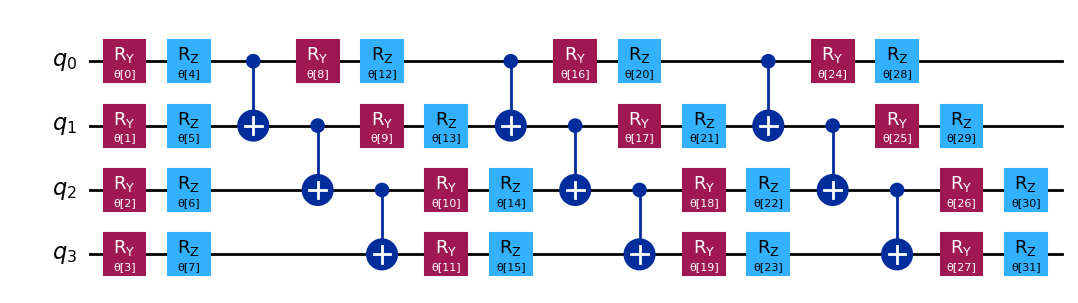

full entanglement:


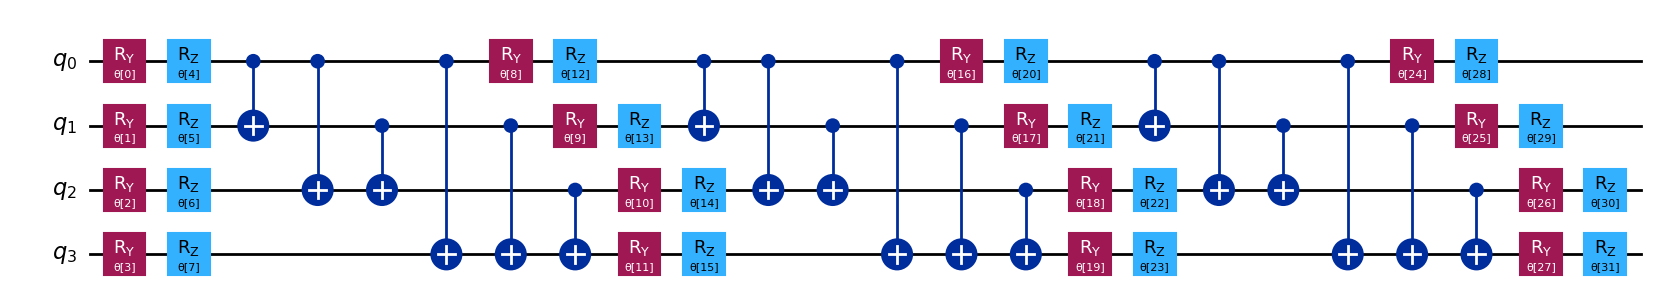

In [7]:
from qiskit.circuit.library import EfficientSU2

entanglements = ["linear", "full"]
for entanglement in entanglements:
    form = EfficientSU2(num_qubits=4, entanglement=entanglement)
    print(f"{entanglement} entanglement:")
    # We initialize all parameters to 0 for this demonstration
    display(form.decompose().draw("mpl", fold=-1))

In [8]:
from qiskit_algorithms import MinimumEigensolverResult
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.circuit.library import EfficientSU2
import numpy as np
from qiskit_algorithms.optimizers import SLSQP , SPSA , ADAM
from qiskit_aer.primitives import Estimator
#qiskit_nature.settings.use_pauli_sum_op = False 
from qiskit_aer import Aer
from pyinstrument import Profiler
import threading
from qiskit_aer.primitives import Estimator as AerEstimator
import math
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator
import cupy as cp
import matplotlib.pyplot as plt



In [9]:



def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["Be", "H" , "H" ],
        coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0] ,[0.0, 0.0 , -dist] ),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [10]:
# from qiskit_aer import *
# from qiskit_aer import Aer

# try:
#     simulator_gpu = Aer.get_backend('aer_simulator_statevector')
#     simulator_gpu.set_options(device='GPU')
#     simulator_gpu.set_options(cuStateVec_enable=False)
#     print("GPU options set successfully." , simulator_gpu)
# except Exception as e:
#     print(f"Failed to set GPU options: {e}")

# print(Aer.backends())

In [11]:


import time


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


start_time = time.time()
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=20)


noiseless_estimator = Estimator(approximation=True)



for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
 
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")
end_time = time.time()
execution_time1 = end_time - start_time
print(f"Execution time: {execution_time1} seconds")

Interatomic Distance: 0.5 VQE Result: -13.50343 Exact Energy: -13.50357
Interatomic Distance: 0.7 VQE Result: -14.77767 Exact Energy: -14.77777
Interatomic Distance: 0.9 VQE Result: -15.27480 Exact Energy: -15.27492
Interatomic Distance: 1.1 VQE Result: -15.46121 Exact Energy: -15.46141
Interatomic Distance: 1.3 VQE Result: -15.51124 Exact Energy: -15.51160
Interatomic Distance: 1.5 VQE Result: -15.49949 Exact Energy: -15.50020
Interatomic Distance: 1.7 VQE Result: -15.46139 Exact Energy: -15.46288
Interatomic Distance: 1.9 VQE Result: -15.41556 Exact Energy: -15.41875
Interatomic Distance: 2.1 VQE Result: -15.37305 Exact Energy: -15.37951
Interatomic Distance: 2.3 VQE Result: -15.34184 Exact Energy: -15.35271
Interatomic Distance: 2.5 VQE Result: -15.32489 Exact Energy: -15.34013
Interatomic Distance: 2.7 VQE Result: -15.31871 Exact Energy: -15.33635
Interatomic Distance: 2.9 VQE Result: -15.31910 Exact Energy: -15.33576
Interatomic Distance: 3.1 VQE Result: -15.32289 Exact Energy: -1

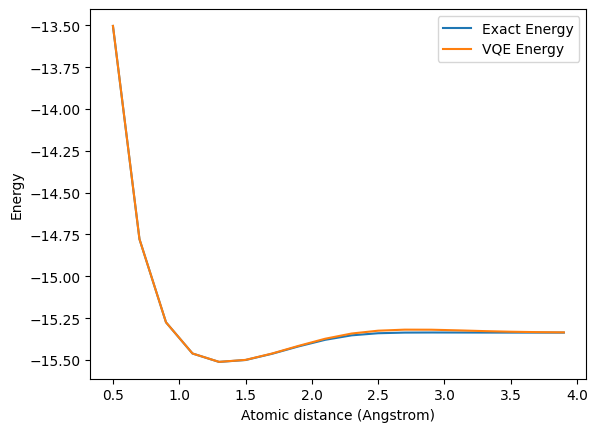

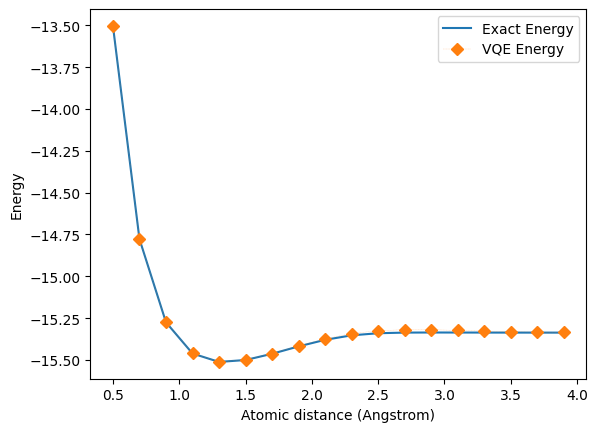

<Figure size 640x480 with 0 Axes>

In [12]:

plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()
plt.savefig("img1")

plt.plot(distances, exact_energies, label="Exact Energy", ls='-', linewidth=1.5)
plt.plot(distances, vqe_energies, label="VQE Energy", ls=':', marker='D', linewidth=0.2)
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()
plt.savefig("img2")

In [13]:
from qiskit_aer.primitives import Estimator
from qiskit_aer import *
import matplotlib.pyplot as plt
import numpy as np
import psutil
import time
import ray
import os

start_time = time.time()
ray.shutdown()
ray.init()

distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
times = []
pids = []
cpu_name = []
optimizer = SLSQP(maxiter=20)
noiseless_estimator = Estimator(approximation=True)

# backend= {
#     "method": "statevector",
#     "precision": "double",
#     "max_parallel_threads": 4,
#     "device": "GPU"
# }
# noiseless_estimator = AerEstimator(backend_options = backend , approximation=True)


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


@ray.remote
def compute_energy(dist):
        pid = os.getpid()
        p = psutil.Process(pid)
        affinity = p.cpu_num()
        qubit_op, num_particles, num_spatial_orbitals, problem, mapper = get_qubit_op(dist)
        start = time.time()
        result = exact_solver(qubit_op, problem)
        exact_energy = result.total_energies[0].real   
        init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)

        var_form = UCCSD(
            num_spatial_orbitals, num_particles, mapper, initial_state=init_state
        )
        vqe = VQE(
            noiseless_estimator,
            var_form,
            optimizer,
            initial_point=[0] * var_form.num_parameters,
            
        )

        vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
        vqe_result = problem.interpret(vqe_calc).total_energies[0].real
        end = time.time()
        computation_time = end - start
        return dist , exact_energy, vqe_result , computation_time , pid , affinity

results = [compute_energy.remote(dist) for dist in distances]


for result in ray.get(results):
   
    dist, exact_energy, vqe_result , computation_time , pid , affinity   = result
    exact_energies.append(exact_energy)
    vqe_energies.append(vqe_result)
    times.append(computation_time)
    pids.append(pid)
    cpu_name.append(affinity)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energy:.5f}",
          f"ComputationTime: {computation_time:.5f} sec "
          f"PID NO = : {pid} "
          f"CPU Number: {affinity} "

          )
          
print("All energies have been calculated")
end_time = time.time()
execution_time2 = end_time - start_time
print(f"Execution time: {execution_time2} seconds")

ray.shutdown()


2024-09-04 13:25:10,029	INFO worker.py:1788 -- Started a local Ray instance.


(compute_energy pid=2875944) *** SIGSEGV received at time=1725436792 on cpu 55 ***
(compute_energy pid=2875944) PC: @     0x55931b2696c0  (unknown)  PyTuple_New
(compute_energy pid=2875944)     @     0x7f7209805d20  (unknown)  (unknown)
(compute_energy pid=2875944) [2024-09-04 13:29:52,061 E 2875944 2881700] logging.cc:440: *** SIGSEGV received at time=1725436792 on cpu 55 ***
(compute_energy pid=2875944) [2024-09-04 13:29:52,061 E 2875944 2881700] logging.cc:440: PC: @     0x55931b2696c0  (unknown)  PyTuple_New
(compute_energy pid=2875944) [2024-09-04 13:29:52,061 E 2875944 2881700] logging.cc:440:     @     0x7f7209805d20  (unknown)  (unknown)
(compute_energy pid=2875944) Fatal Python error: Segmentation fault
(compute_energy pid=2875944) 
(compute_energy pid=2875944) Stack (most recent call first):
(compute_energy pid=2875944)   File "/home/ketanm/miniconda3/envs/qiskit1.1/lib/python3.9/site-packages/qiskit_aer/backends/aer_compiler.py", line 656 in assemble_circuit
(compute_energy 

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 2fce64d5b3223d15f39d2a1e48cc7990aad075b801000000 Worker ID: 0f305a290d8bcc5b31bfd0da020a6e6289df5f6215becb1c9da0972d Node ID: c93dd793f7d5343a123712ec03406b3d1d4983681294872dd9bbb0ce Worker IP address: 10.180.146.19 Worker port: 41017 Worker PID: 2875944 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.
Interatomic Distance: 0.5 VQE Result: -13.50343 Exact Energy: -13.50357 ComputationTime: 193.75357 sec PID NO = : 2875961 CPU Number: 7 
Interatomic Distance: 0.7 VQE Result: -14.77767 Exact Energy: -14.77777 ComputationTime: 

In [14]:
speedup = execution_time1/execution_time2
print(f"total speed up {speedup}x" )

total speed up 7.211809355245925x


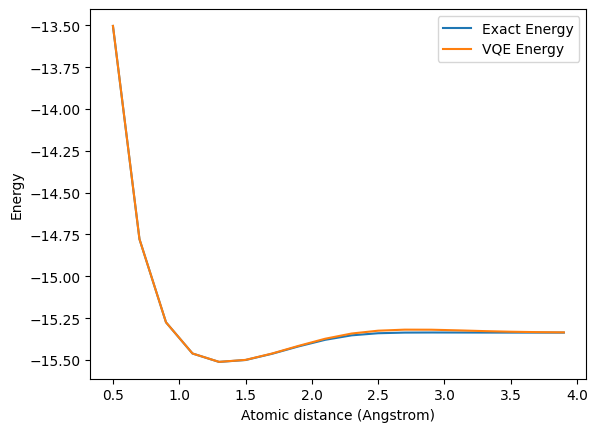

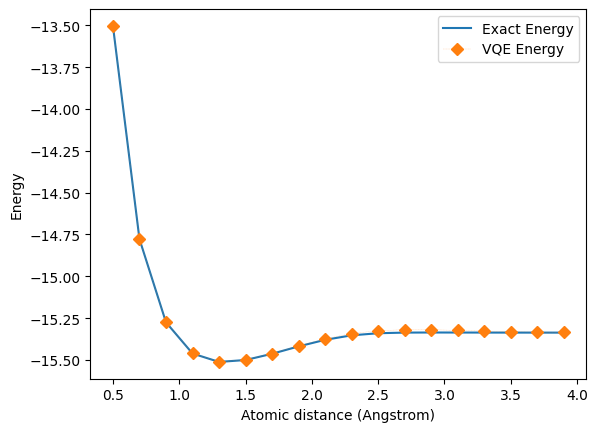

<Figure size 640x480 with 0 Axes>

In [15]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()
plt.savefig("img1")

plt.plot(distances, exact_energies, label="Exact Energy", ls='-', linewidth=1.5)
plt.plot(distances, vqe_energies, label="VQE Energy", ls=':', marker='D', linewidth=0.2)
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()
plt.savefig("img2")

